# FX vol trading strategy - implementation

In [99]:
# Import libraries
import pandas as pd
import numpy as np
from data_cleaning.import_data import import_data
from utils.garch import get_rolling_vol_forecasts
from utils.plots import plot_trades
from utils.trading_strategy import gen_trading_signals
from arch import arch_model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pick FX pair and set up model

In [96]:
# Load return data
pair = 'USDBRL'
df = import_data(fx_pair=pair)
df.dropna(inplace=True)
returns = df['log_ret'] * 100

# arch model
model = arch_model(returns, mean='AR', vol='GARCH', p=2,q=1, dist = 'Studentst')


## Forecast volatility

In [97]:
# Conditional volatility forecasting
vol_forecasts = get_rolling_vol_forecasts(return_series=returns, 
                                            model=model, 
                                            horizon=21,
                                            fitting_end_date="2021-01-01",
                                            )
vol_forecasts = vol_forecasts.multiply(np.sqrt(252))

df = df.merge(vol_forecasts['h.21'], left_index=True, right_index=True)
df.rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
df['cond_forecast_to_implied'] = df['cond_vol_forecast'] / df['v1m']
df

Number of forecasts: 298
..........................................................................................................................................................................................................................................................................................................

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,cond_vol_forecast,cond_forecast_to_implied
2021-01-01,21.290,19.388,17.515,5.1985,5.1966,5.2003,0.000000,0.005956,13.676756,0.642403
2021-01-04,21.630,19.620,17.413,5.2717,5.2710,5.2725,0.013983,0.020671,15.759419,0.728591
2021-01-05,22.522,19.908,17.700,5.2766,5.2761,5.2770,0.000929,0.024726,14.530992,0.645191
2021-01-06,21.730,19.390,17.445,5.3006,5.2997,5.3015,0.004538,0.026279,13.757272,0.633100
2021-01-07,21.823,19.895,17.500,5.4009,5.4004,5.4015,0.018746,0.033277,18.266415,0.837026
...,...,...,...,...,...,...,...,...,...,...
2022-02-16,15.680,16.052,17.382,5.1293,5.1289,5.1297,-0.007749,0.062050,12.018819,0.766506
2022-02-17,16.292,16.145,17.470,5.1697,5.1693,5.1701,0.007845,0.039373,12.136187,0.744917
2022-02-18,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,0.042668,11.832145,0.759201
2022-02-21,15.955,16.188,17.515,5.1064,5.1060,5.1068,-0.006325,0.049435,11.633602,0.729151


## Generate trading signals

In [102]:
threshold_up = 1.1
threshold_down = 0.9

gen_trading_signals(df,thres_up=threshold_up,thres_down=threshold_down)
df.tail(10)

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,cond_vol_forecast,cond_forecast_to_implied,direction,direction_flag
2022-02-09,14.905,15.815,17.465,5.2347,5.2343,5.2350,-0.004555,0.047339,13.300773,0.892370,0,nan
2022-02-10,14.855,15.667,17.375,5.2497,5.2491,5.2502,0.002861,0.037994,12.537475,0.843990,0,nan
2022-02-11,16.075,16.202,17.590,5.2490,5.2484,5.2495,-0.000133,0.039271,11.715653,0.728812,0,nan
2022-02-14,16.472,16.658,17.750,5.2189,5.2186,5.2193,-0.005751,0.043496,11.414235,0.692948,0,nan
2022-02-15,16.125,16.430,17.490,5.1692,5.1687,5.1696,-0.009569,0.050045,11.950749,0.741132,0,nan
2022-02-16,15.680,16.052,17.382,5.1293,5.1289,5.1297,-0.007749,0.062050,12.018819,0.766506,0,nan
2022-02-17,16.292,16.145,17.470,5.1697,5.1693,5.1701,0.007845,0.039373,12.136187,0.744917,0,nan
2022-02-18,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,0.042668,11.832145,0.759201,0,nan
2022-02-21,15.955,16.188,17.515,5.1064,5.1060,5.1068,-0.006325,0.049435,11.633602,0.729151,0,nan
2022-02-22,15.900,16.160,17.487,5.1064,5.1060,5.1068,0.000000,0.054879,10.900086,0.685540,-1,Sell straddle


## How does the trades look?

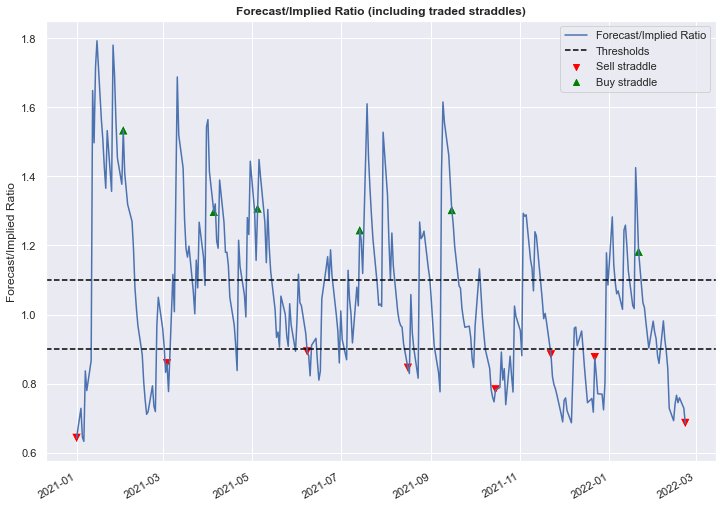

In [104]:
plot_trades(df,thres_up=threshold_up,thres_down=threshold_down)